## Поиск и выбор набора данных для построения моделей машинного обучения

В качестве набора данных мы будем использовать набор данных об аренде велосипедов - https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset

Датасет содержит следующие параметры:
- "timestamp" - время
- "cnt" - количество арендованных велосипедов
- "t1" - действительная температура в градусай Цельсия
- "t2" - температура по ощущениям в граудсах Цельсия
- "hum" - влажность
- "wind_speed" - скорость ветра в км/ч
- "weather_code" - категория погоды (насколько плохая погода)
- "is_holiday" - является ли день праздничным
- "is_weekend" - является ли день выходным
- "season" - время года: 0-весна ; 1-лето; 2-очень; 3-зима.

Будем решать задачу регрессии. В качестве целевого признака будем использовать "cnt".

## Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

RANDOM_STATE = 123

## Загрузка данных

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/datasets/london_merged.csv', sep=",")

## Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

### Основные характеристики датасета

In [ ]:
data.shape

(17414, 10)

In [ ]:
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [ ]:
data.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [ ]:
data.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [ ]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

### Построение графиков для понимания структуры данных

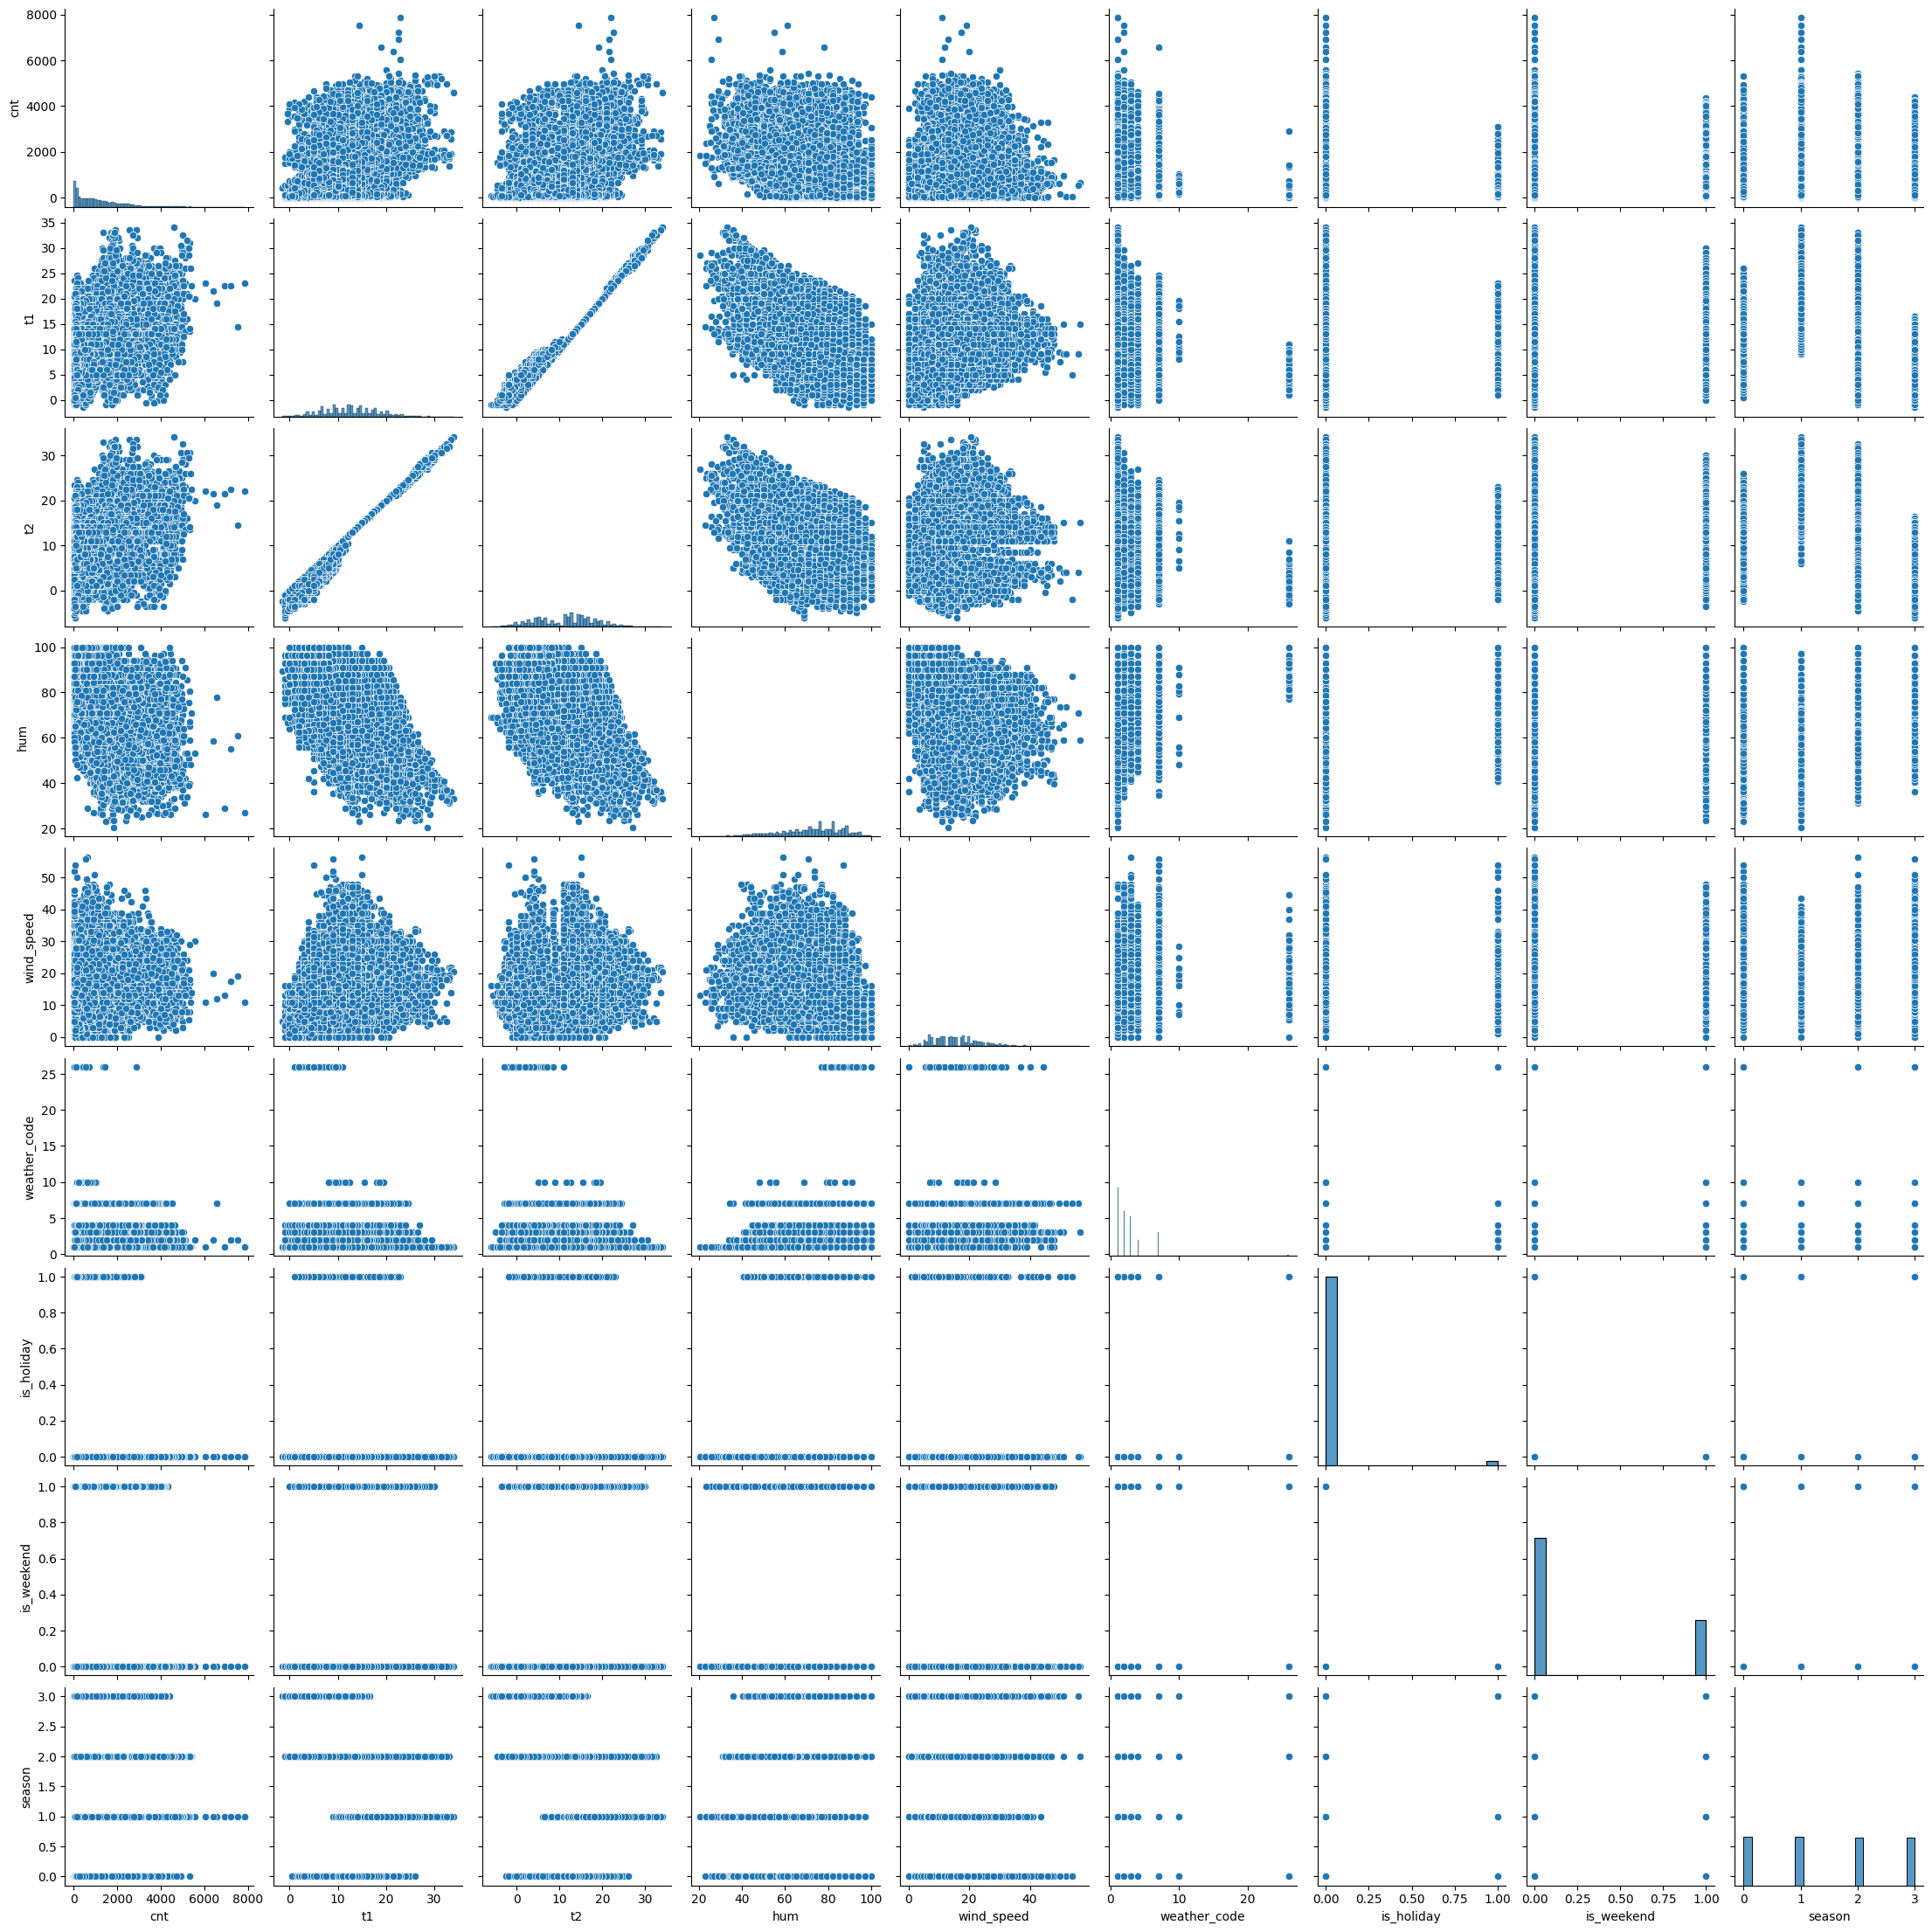

In [ ]:
sns.pairplot(data)

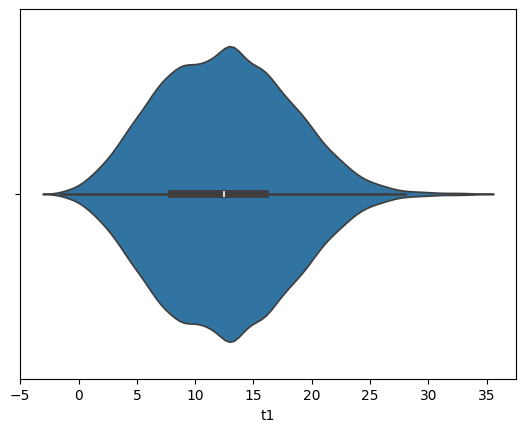

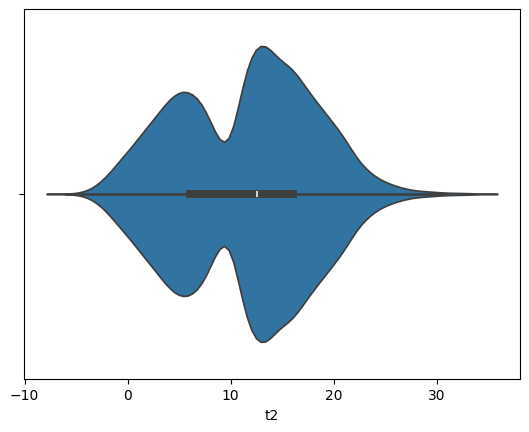

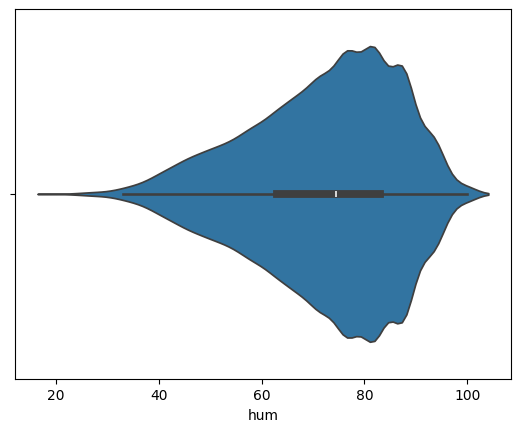

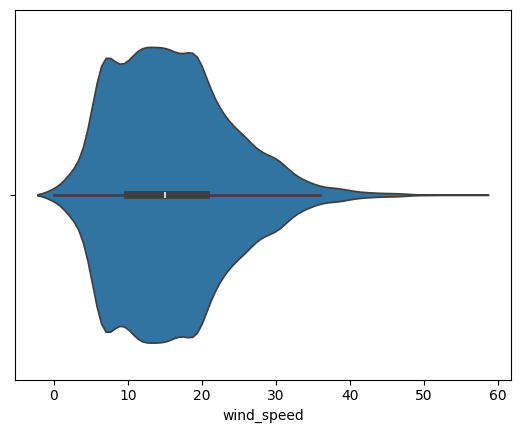

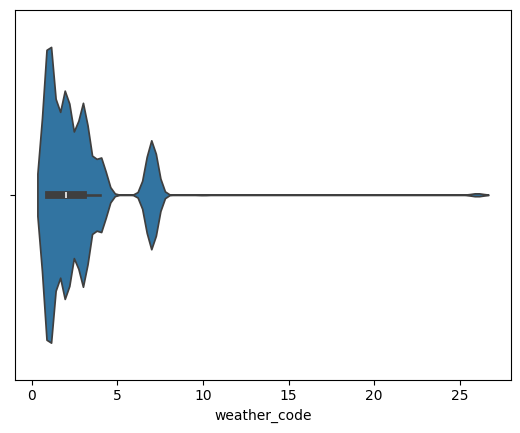

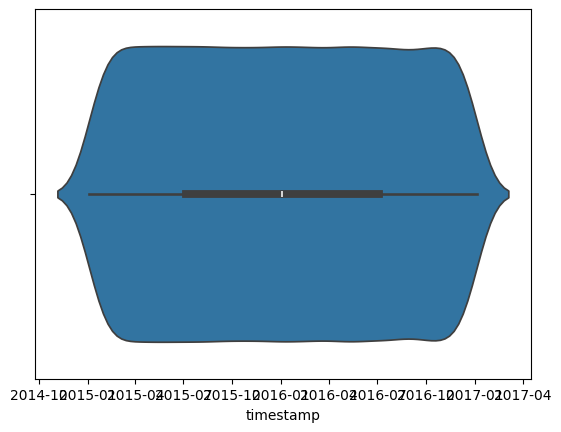

In [ ]:
for col in ['t1', 't2', 'hum', 'wind_speed', 'weather_code', 'timestamp']:
    sns.violinplot(x=data[col])
    plt.show()

### Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

In [ ]:
data.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

Для построения моделей будем использовать все признаки кроме признака timestamp, потому что мы не рассматриваем наши данные как временной ряд.

Категориальные признаки уже закодированы на основе метода LabelEncoding. Перекодируем признак season при помощи метода OneHotEncoding, чтобы избежать неправильной интерпретации данных, как упорядоченных.

Построим вспомогательный признак времени суток "hour" на основе timestamp.

Выполним масштабирование данных.

In [ ]:
data['hour'] = data['timestamp'].dt.hour

In [ ]:
data = pd.get_dummies(data, columns=['season'], prefix='season')

In [ ]:
numeric_columns = ['t1', 't2', 'hum', 'wind_speed', 'weather_code', 'hour']
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[numeric_columns])

In [ ]:
for i in range(len(numeric_columns)):
    col = numeric_columns[i]
    new_col_name = col + '_scaled'
    data[new_col_name] = data_scaled[:,i]

In [ ]:
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,hour,season_0.0,season_1.0,season_2.0,season_3.0,t1_scaled,t2_scaled,hum_scaled,wind_speed_scaled,weather_code_scaled,hour_scaled
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,0,False,False,False,True,0.126761,0.2000,0.911950,0.106195,0.08,0.000000
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,1,False,False,False,True,0.126761,0.2125,0.911950,0.088496,0.00,0.043478
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,2,False,False,False,True,0.112676,0.2125,0.955975,0.000000,0.00,0.086957
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3,False,False,False,True,0.098592,0.2000,1.000000,0.000000,0.00,0.130435
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,4,False,False,False,True,0.098592,0.1500,0.911950,0.115044,0.00,0.173913


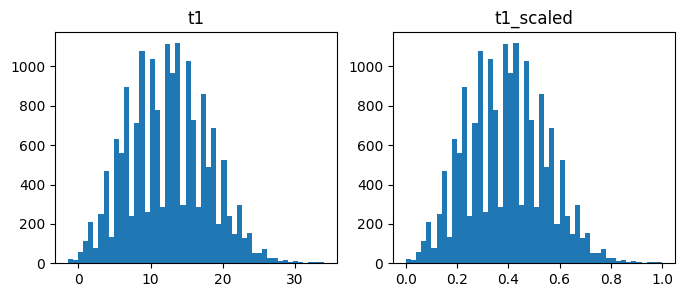

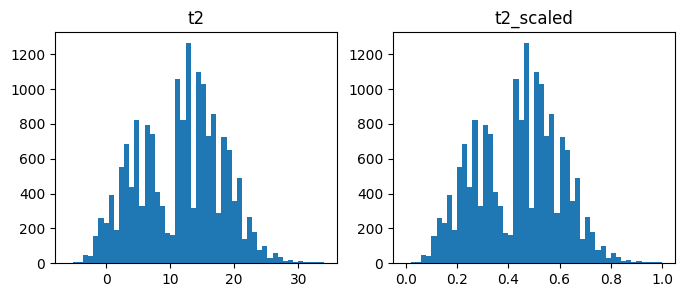

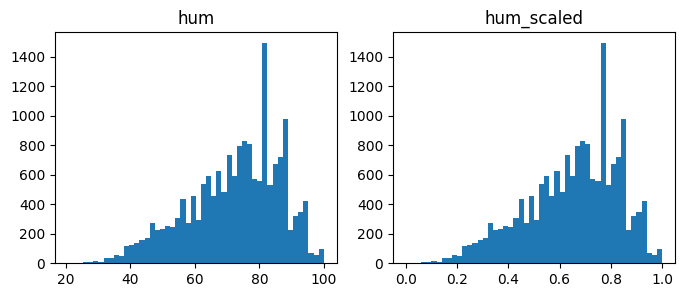

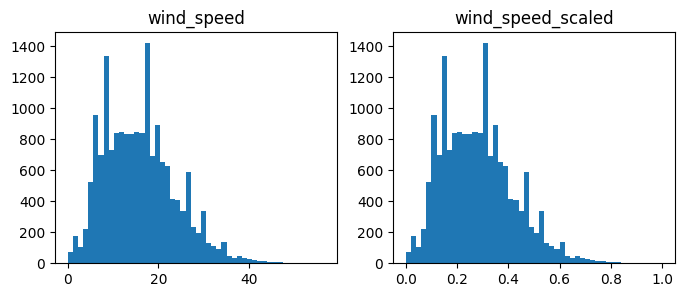

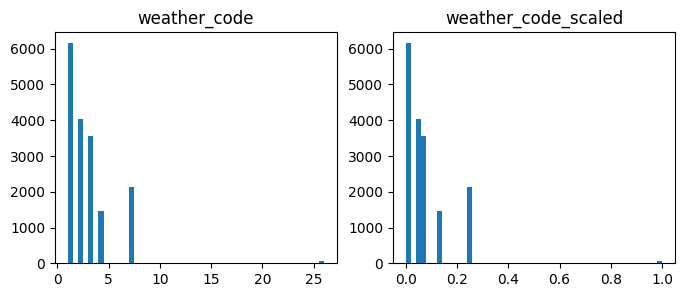

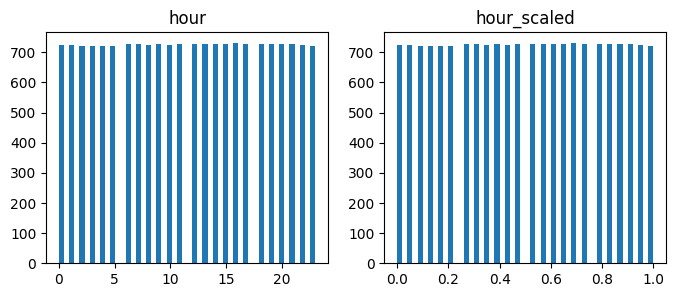

In [ ]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in numeric_columns:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(data[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

## Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.

In [ ]:
correlation_column = numeric_columns + ['cnt']
correlation_column

['t1', 't2', 'hum', 'wind_speed', 'weather_code', 'hour', 'cnt']

In [ ]:
correlation_column_postfix = [x+'_scaled' for x in numeric_columns]
correlation_column_2 = correlation_column_postfix + ['cnt']
correlation_column_2

['t1_scaled',
 't2_scaled',
 'hum_scaled',
 'wind_speed_scaled',
 'weather_code_scaled',
 'hour_scaled',
 'cnt']

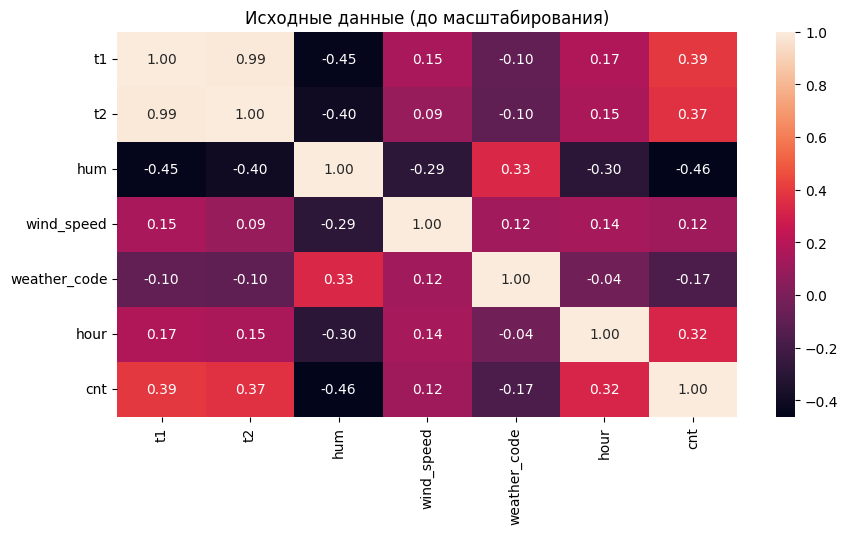

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[correlation_column].corr(), annot=True, fmt='.2f')
ax.set_title('Исходные данные (до масштабирования)')
plt.show()

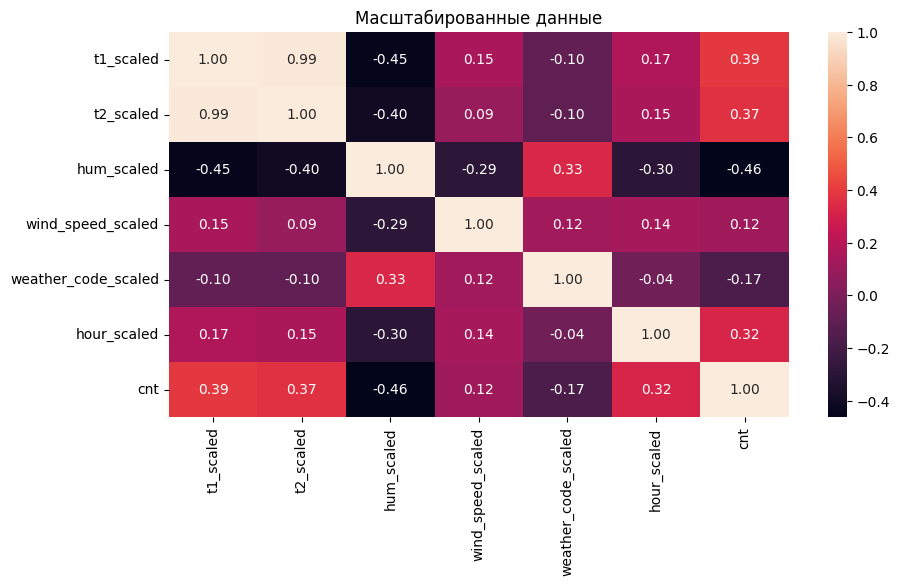

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[correlation_column_2].corr(), annot=True, fmt='.2f')
ax.set_title('Масштабированные данные')
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы:

- Корреляционные матрицы для исходных и масштабированных данных совпадают.
- Целевой признак регрессии "cnt" наиболее сильно коррелирует с "hum" (-0.46), температурой (0.39 и 0.37) и временем суток. Эти признаки обязательно следует оставить в модели регрессии.
- Признаки "t1" и "t2" имеют корреляцию, близкую по модулю к 1, поэтому оба признака не следуют включать в модели. Будем использовать признак "t1", так как он лучше чем "t2" коррелирует с остальными признаками.
- Большие по модулю значения коэффициентов корреляции свидетельствуют о значимой корреляции между исходными признаками и целевым признаком. На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения.

## Выбор метрик для последующей оценки качества моделей.

#### Mean absolute error - средняя абсолютная ошибка

$MAE(y,\hat{y}) = \frac{1}{N} \cdot \sum\limits_{i=1}^N \lvert  y_i - \hat{y_i} \rvert $

где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $N$ - размер тестовой выборки

Чем ближе значение к нулю, тем лучше качество регрессии.

Основная проблема метрики состоит в том, что она не нормирована.

Вычисляется с помощью функции [mean_absolute_error.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error)

#### Mean squared error - средняя квадратичная ошибка

$MSE(y,\hat{y}) = \frac{1}{N} \cdot \sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2 $

где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $N$ - размер тестовой выборки

Вычисляется с помощью функции [mean_squared_error.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)

#### Метрика $R^2$ или коэффициент детерминации

$R^2(y,\hat{y}) = 1 - \frac{\sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2}{\sum\limits_{i=1}^N ( y_i - \overline{y_i} )^2} $

где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $N$ - размер тестовой выборки
- $\overline{y_i} = \frac{1}{N} \cdot \sum\limits_{i=1}^N y_i $

Вычисляется с помощью функции [r2_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)

### Сохранение и визуализация метрик

In [ ]:
class MetricLogger:

    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric'] == metric) & (self.df['alg'] == alg)].index, inplace=True)
        # Добавление нового значения
        temp = pd.DataFrame([{'metric': metric, 'alg': alg, 'value': value}])
        self.df = pd.concat([self.df, temp], ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric'] == metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values

    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5,
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a, b in zip(pos, array_metric):
            plt.text(0.5, a - 0.05, str(round(b, 3)), color='white')
        plt.show()

In [ ]:
metricLogger = MetricLogger()

## Выбор моделей

- Линейная регрессия
- Метод опорных векторов
- Градиентный бустинг
- Бэггинг
- Дерево решений

## Формирование обучающей и тестовой выборок на основе исходного набора данных.

In [ ]:
data.columns

Index(['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'is_holiday', 'is_weekend', 'hour', 'season_0.0', 'season_1.0',
       'season_2.0', 'season_3.0', 't1_scaled', 't2_scaled', 'hum_scaled',
       'wind_speed_scaled', 'weather_code_scaled', 'hour_scaled'],
      dtype='object')

In [ ]:
numeric_columns

['t1', 't2', 'hum', 'wind_speed', 'weather_code', 'hour']

In [ ]:
y = data.cnt
X = data[['t1_scaled', 'hum_scaled', 'wind_speed_scaled', 'weather_code_scaled', 'hour_scaled', 'is_holiday', 'is_weekend', 'season_0.0',	'season_1.0',	'season_2.0',	'season_3.0']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

## Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

In [ ]:
def train_model(model_name, model, MetricLogger):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metricLogger.add('MAE', model_name, mae)
    metricLogger.add('MSE', model_name, mse)
    metricLogger.add('R2', model_name, r2)

    print('{:10} \t MAE={}\t MSE={}\t\t R2={}'.format(
        model_name, round(mae, 2), round(mse, 2), round(r2, 3)))

In [ ]:
models = {'LR_b': LinearRegression(),
          'SVC_b':SVR(),
          'GB_b':GradientBoostingRegressor(random_state=RANDOM_STATE),
          'Baggin_b': BaggingRegressor(random_state=RANDOM_STATE),
          'Tree_b':DecisionTreeRegressor(random_state=RANDOM_STATE)}

In [ ]:
for model_name, model in models.items():
    train_model(model_name, model, metricLogger)

LR_b       	 MAE=672.91	 MSE=826178.44		 R2=0.299
SVC_b      	 MAE=706.62	 MSE=1075450.38		 R2=0.088
GB_b       	 MAE=235.2	 MSE=122396.78		 R2=0.896
Baggin_b   	 MAE=149.01	 MSE=64463.44		 R2=0.945
Tree_b     	 MAE=197.98	 MSE=121027.4		 R2=0.897


## Подбор гиперпараметров для выбранных моделей.

In [ ]:
# Линейная регрессия
lr_params = {
    'fit_intercept': [True, False],
}

grid_search = GridSearchCV(estimator=LinearRegression(), param_grid=lr_params, cv=5)
grid_search.fit(X_train, y_train)

lr_best_params = grid_search.best_params_
print(f"Лучшие параметры: {lr_best_params}")

Лучшие параметры: {'fit_intercept': False}


In [ ]:
# Метод опорных векторов
# svr_params = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
# }
svr_params = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10]},
    {'kernel': ['sigmoid'], 'C': [0.1, 1, 10]}
]

grid_search = GridSearchCV(estimator=SVR(), param_grid=svr_params, cv=3)
grid_search.fit(X_train, y_train)

svr_best_params = grid_search.best_params_
print(f"Лучшие параметры: {svr_best_params}")

Лучшие параметры: {'C': 10, 'degree': 4, 'kernel': 'poly'}


In [ ]:
# Градиентный бустинг
gb_params = {
    'n_estimators':[50, 100, 150, 200]
}

grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=RANDOM_STATE), param_grid=gb_params, cv=3)
grid_search.fit(X_train, y_train)

gb_best_params = grid_search.best_params_
print(f"Лучшие параметры: {gb_best_params}")

Лучшие параметры: {'n_estimators': 200}


In [ ]:
# Бэггинг
bagging_params = {
    'n_estimators':[5, 10, 50, 100]
}

grid_search = GridSearchCV(estimator=BaggingRegressor(random_state=RANDOM_STATE), param_grid=bagging_params, cv=3)
grid_search.fit(X_train, y_train)

bagging_best_params = grid_search.best_params_
print(f"Лучшие параметры: {bagging_best_params}")

Лучшие параметры: {'n_estimators': 100}


In [ ]:
# Дерево решений
tree_params = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 1.0, 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=RANDOM_STATE), param_grid=tree_params, cv=3)
grid_search.fit(X_train, y_train)

tree_best_params = grid_search.best_params_
print(f"Лучшие параметры: {tree_best_params}")

Лучшие параметры: {'criterion': 'poisson', 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 20}


## Обучение моделей с оптимальными значениями гиперпараметров

In [ ]:
# Модели
optimal_models = {
          'LR': LinearRegression(fit_intercept=False),
          'SVC':SVR(kernel='poly', degree=4, C=10),
          'GB':GradientBoostingRegressor(n_estimators=200, random_state=RANDOM_STATE),
          'Baggin': BaggingRegressor(n_estimators=100, random_state=RANDOM_STATE),
          'Tree':DecisionTreeRegressor(criterion='poisson', min_samples_split=20, min_samples_leaf=5, max_features=None, random_state=RANDOM_STATE)
          }

In [ ]:
for model_name, model in optimal_models.items():
    train_model(model_name, model, metricLogger)

LR         	 MAE=672.91	 MSE=826178.44		 R2=0.299
SVC        	 MAE=510.13	 MSE=743293.99		 R2=0.37
GB         	 MAE=183.54	 MSE=81635.63		 R2=0.931
Baggin     	 MAE=144.53	 MSE=60108.67		 R2=0.949
Tree       	 MAE=168.92	 MSE=80980.91		 R2=0.931


## Выводы

In [ ]:
# Метрики качества модели
metrics = metricLogger.df['metric'].unique()
metrics

array(['MAE', 'MSE', 'R2'], dtype=object)

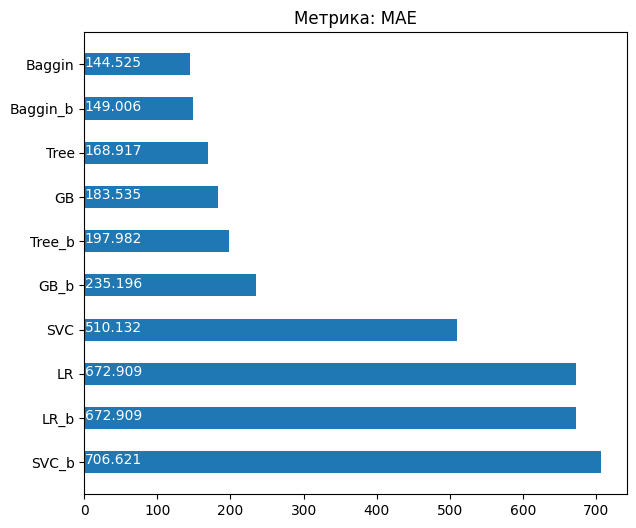

In [ ]:
metricLogger.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(7, 6))

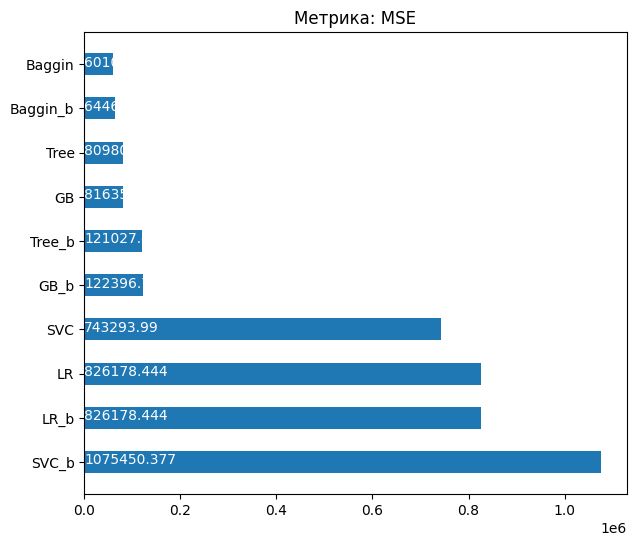

In [ ]:
metricLogger.plot('Метрика: ' + 'MSE', 'MSE', ascending=False, figsize=(7, 6))

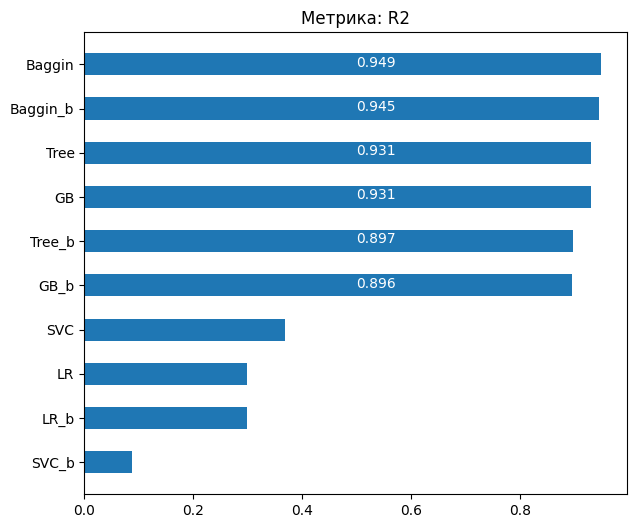

In [ ]:
metricLogger.plot('Метрика: ' + 'R2', 'R2', ascending=True, figsize=(7, 6))

### Визуализация дерева

In [ ]:
!apt-get install graphviz -y
!pip install graphviz pydotplus

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

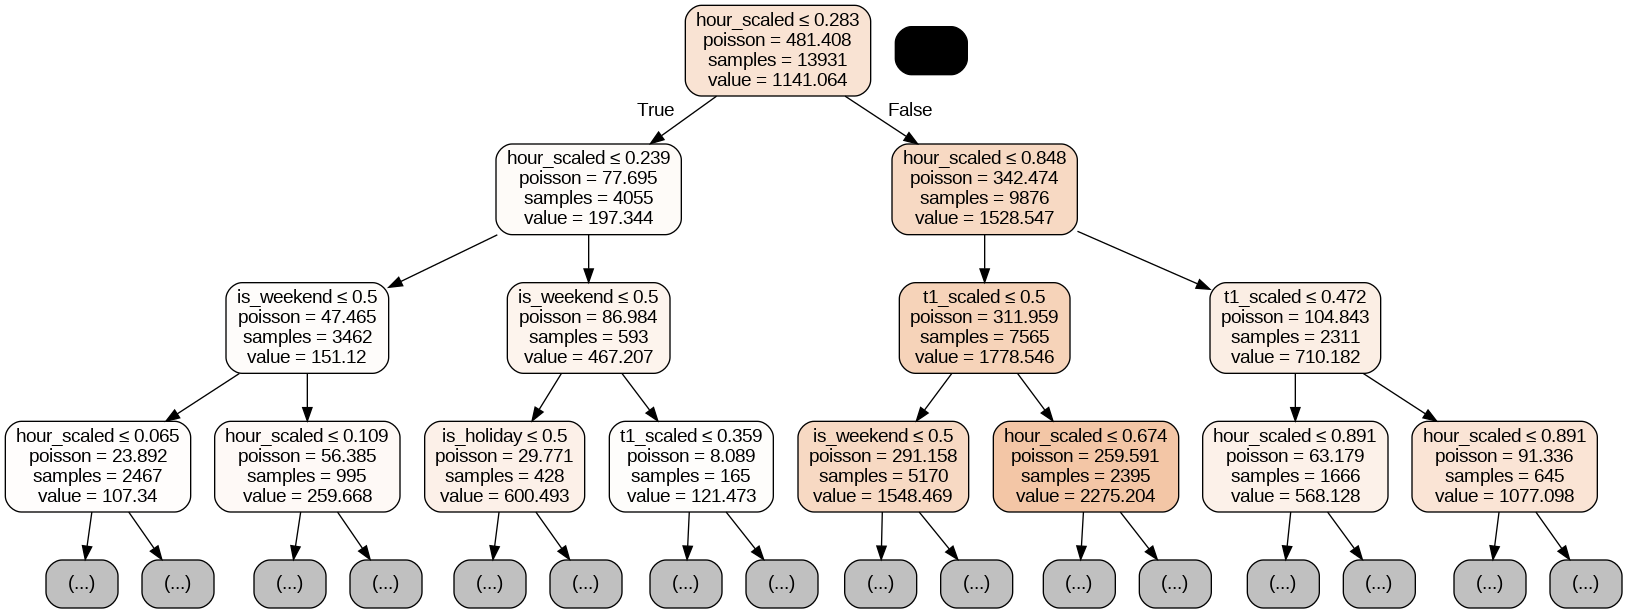

In [ ]:
dot_data = export_graphviz(optimal_models['Tree'],
                           out_file=None,
                           feature_names=X.columns,
                           filled=True, rounded=True,
                           special_characters=True,
                           max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

По построенному дереву можно увидеть, что самым важным параметром является время. В промежутке от 7 до 20 часов вторым по важности является температура, а в промежутке от 6 до 7 - является ли день выходным.

Наиболее эффективными оказались модели на основе решающего дерева и бустинга.
Я думаю, что причина в том, что самым значимым параметром оказалось время, которое имеет нелинейную зависимость с количеством поездок. Модели на основе деревьев лучше обработали промежутки времени.

Подбор параметров больше всего повлиял на SVC модель, хотя она так и не смогла показать хорошего результата. Обычное дерево решений и градиентный бустинг улучили метрику MSE, за счёт лучшей обработки краевых случаев, что подтверждается улучшением $R^{2}$